In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.info()

X = df.drop(columns=["Close"])
y = df["Close"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3201 entries, 2005-02-25 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     3201 non-null   float64
 1   High     3201 non-null   float64
 2   Low      3201 non-null   float64
 3   Close    3201 non-null   float64
 4   Volume   3201 non-null   int64  
 5   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 175.1 KB


In [3]:
X_train.head()

,Open,High,Low,Volume,OpenInt
Date,,,,,
2007-05-21,132.92,133.50,132.85,113251341,0
2006-04-10,112.99,113.33,112.61,47685748,0
2010-12-20,108.57,108.82,108.00,136661367,0
2011-06-01,117.67,118.04,115.28,266196889,0
2008-05-12,121.30,122.46,120.86,173229666,0


In [4]:
y_train.head()

Date
2007-05-21    132.89
2006-04-10    113.02
2010-12-20    108.54
2011-06-01    115.38
2008-05-12    122.39
Name: Close, dtype: float64

In [7]:
# Step 3: Initialize a base model (e.g., DecisionTreeRegressor)
base_model = DecisionTreeRegressor(random_state=42)

# Step 4: Initialize the BaggingRegressor using the base model
bagging_model = BaggingRegressor(estimator=base_model, random_state=42)

# Step 5: Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 200),  # Number of trees in the ensemble
    'max_samples': uniform(0.1, 1.0),  # Proportion of samples to use for each base estimator
    'max_features': uniform(0.1, 1.0),  # Proportion of features to use for each base estimator
    'bootstrap': [True, False],  # Whether to sample with replacement
    'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization error
}

# Step 6: Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=bagging_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random configurations to try
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Step 7: Train the model with RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from the RandomizedSearchCV
best_bagging_model = random_search.best_estimator_

# Step 8: Make predictions on the test set using the best model
y_pred = best_bagging_model.predict(X_test)

# Step 9: Evaluate the performance using Mean Squared Error (MSE), RMSE, MAE, and R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Hyperparameters from RandomizedSearchCV:")
print(random_search.best_params_)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R-squared (R2): {r2:.5f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/Users/thomas/miniconda3/envs/.machine_learning/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reli


Best Hyperparameters from RandomizedSearchCV:
{'bootstrap': True, 'max_features': 0.8282163486118596, 'max_samples': 0.4677831327192532, 'n_estimators': 125, 'oob_score': False}

Model Evaluation:
Mean Squared Error (MSE): 0.51295
Root Mean Squared Error (RMSE): 0.71620
Mean Absolute Error (MAE): 0.47102
R-squared (R2): 0.99975


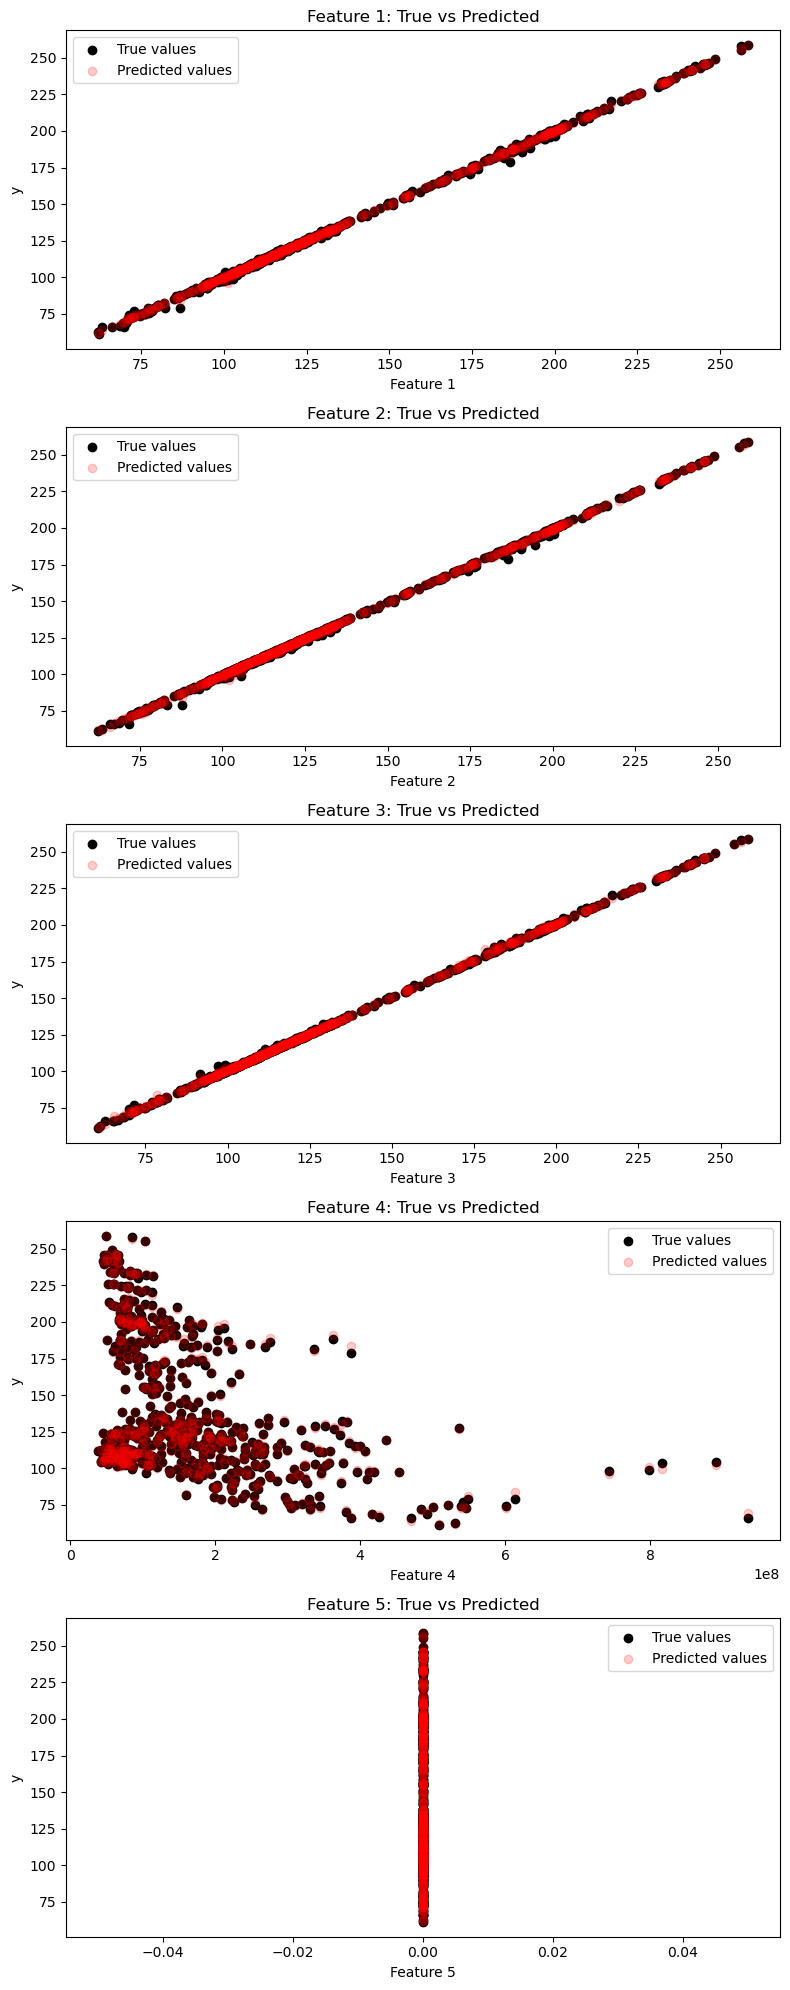

In [11]:
# Step 10: Create subplots to visualize the predictions for each feature in X_test
fig, axes = plt.subplots(5, 1, figsize=(8, 20))  # 2 rows, 4 columns (8 plots total)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot for each feature in X_test
for i in range(5):
    ax = axes[i]
    ax.scatter(X_test.iloc[:, i], y_test, color='black', label='True values')  # True values (y_test)
    ax.scatter(X_test.iloc[:, i], y_pred, color='red', label='Predicted values', alpha=0.2)  # Predicted values (y_pred)
    
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('y')
    ax.set_title(f'Feature {i+1}: True vs Predicted')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


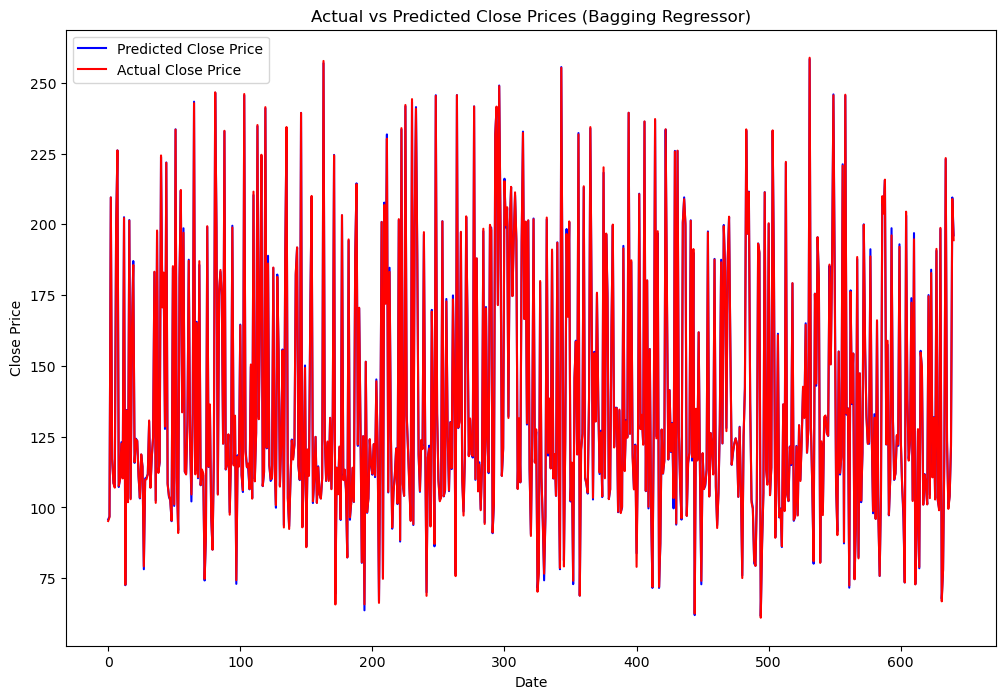

In [13]:
# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
xx = range(len(X_test))
plt.plot(xx, y_pred, label='Predicted Close Price', color='blue')
plt.plot(xx, y_test, label='Actual Close Price', color='red')
plt.title("Actual vs Predicted Close Prices (Bagging Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

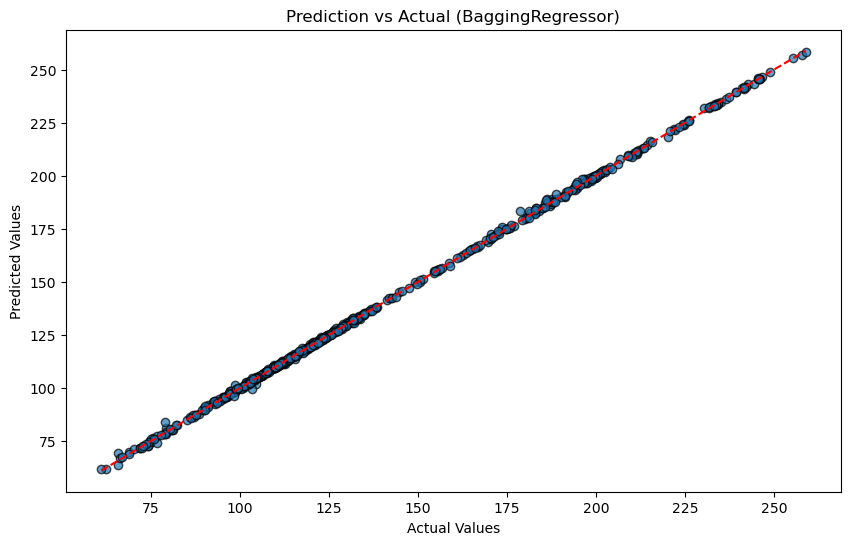

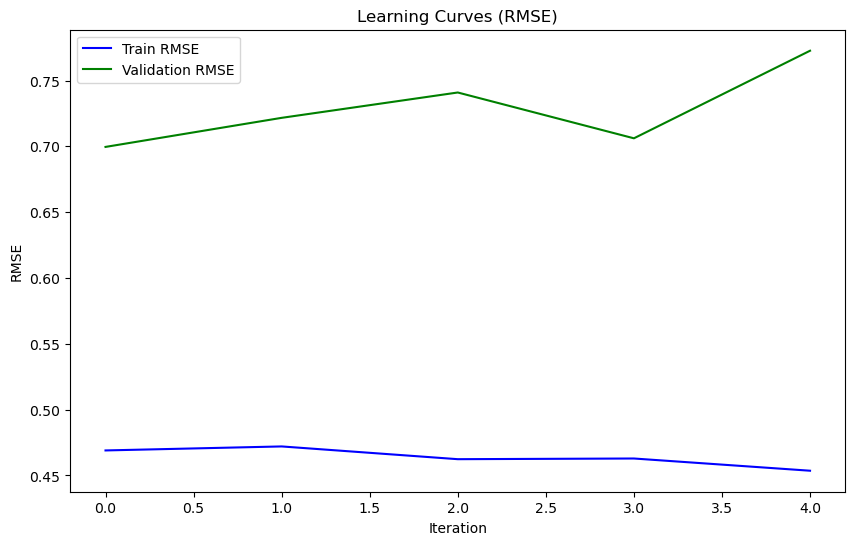

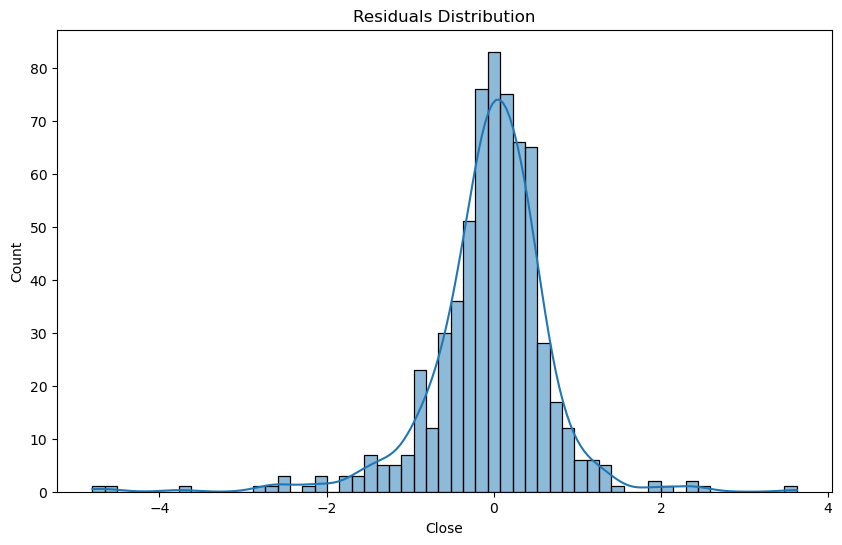

In [16]:

# Set up the figure and axes for plotting
plt.figure(figsize=(10, 6))

# Plot 2: Prediction vs Actuals (scatter plot)
#plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')  # Ideal line
plt.title('Prediction vs Actual (BaggingRegressor)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot 3: Learning curves (Training vs Validation RMSE)
# Manually compute learning curves using KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_errors, val_errors = [], []

for train_index, val_index in kf.split(X_train):
    # Split data into train and validation sets
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on this fold
    best_bagging_model.fit(X_train_cv, y_train_cv)
    
    # Predict on train and validation data
    train_pred = best_bagging_model.predict(X_train_cv)
    val_pred = best_bagging_model.predict(X_val_cv)
    
    # Compute the RMSE for both train and validation sets
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_cv, val_pred))
    
    # Append the errors to the lists
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)


# Plot RMSE learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train RMSE', color='b')
plt.plot(val_errors, label='Validation RMSE', color='g')
plt.title('Learning Curves (RMSE)')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()


# Plot 4: Distribution of residuals (Prediction error)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()